In [2]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

In [3]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Testing.csv')


In [4]:
train_df.shape

(2460, 9)

Dataset Features:

Pregnancies: Number of pregnancies
Glucose: Blood glucose level
BloodPressure: Blood pressure measurement
SkinThickness: Skin thickness measurement
Insulin: Blood insulin level
BMI: Body mass index
DiabetesPedigreeFunction: Diabetes pedigree function (percentage)
Age: Age of the individual
Outcome: Final result (1 for YES, 0 for NO)

In [5]:
train_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
train_df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [7]:
train_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Preprocessing


In [8]:
zero_counts = (train_df == 0).sum()
columns_with_zeros = zero_counts[zero_counts > 0]
print(columns_with_zeros)


Pregnancies       350
Glucose            17
BloodPressure     114
SkinThickness     717
Insulin          1181
BMI                31
Outcome          1500
dtype: int64


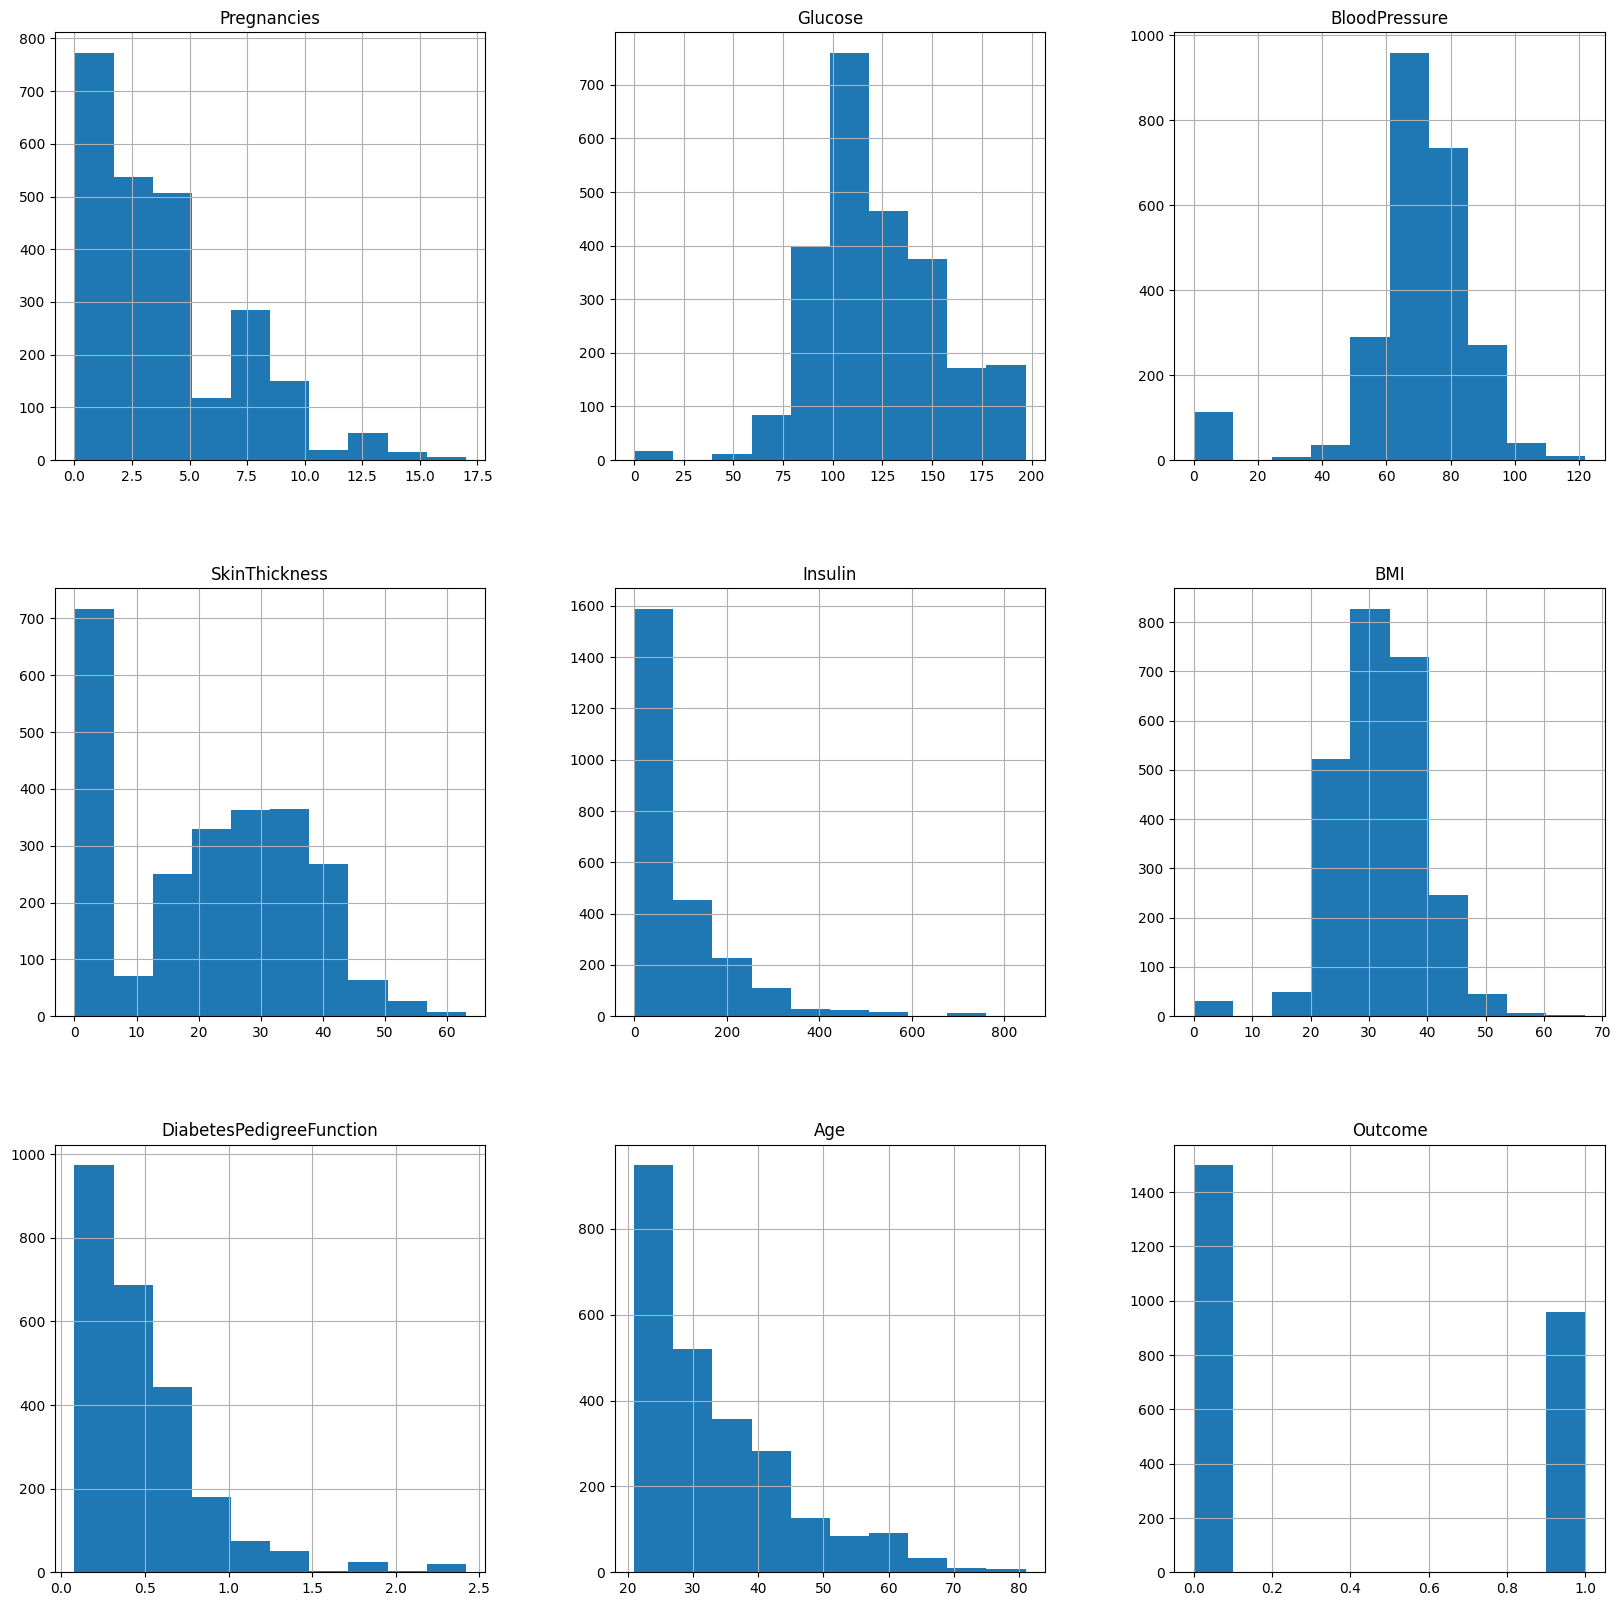

In [9]:
p = train_df.hist(figsize = (20,20))

In [10]:
#large amount of 0's which do not make sense for these columns

print(train_df['Glucose'].mean())
train_df['Glucose'] = train_df['Glucose'].replace(0, train_df['Glucose'].mean())
print(train_df['BloodPressure'].mean())
train_df['BloodPressure'] = train_df['BloodPressure'].replace(0, train_df['BloodPressure'].mean())
print(train_df['SkinThickness'].mean())
train_df['SkinThickness'] = train_df['SkinThickness'].replace(0, train_df['SkinThickness'].mean())
print(train_df['Insulin'].mean())
train_df['Insulin'] = train_df['Insulin'].replace(0, train_df['Insulin'].mean())
print(train_df['BMI'].mean())
train_df['BMI'] = train_df['BMI'].replace(0, train_df['BMI'].mean())

121.60203252032521
68.91504065040651
20.53130081300813
80.119918699187
31.990447154471546


In [11]:
zero_counts = (train_df == 0).sum()
columns_with_zeros = zero_counts[zero_counts > 0]
print(columns_with_zeros)


Pregnancies     350
Outcome        1500
dtype: int64


Outcome
0    1500
1     960
Name: count, dtype: int64


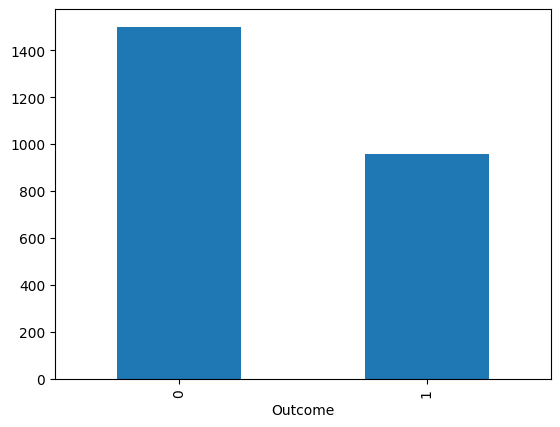

In [12]:
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = train_df["Outcome"].map(lambda x: color_wheel.get(x + 1))
print(train_df.Outcome.value_counts())
p=train_df.Outcome.value_counts().plot(kind="bar")

Preprocessing done


In [13]:
from copy import deepcopy
average_train_df = deepcopy(train_df)

In [14]:
average_train_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,3.817480,122.442372,72.108664,26.515424,118.583993,32.393579,0.491440,32.821951,0.390244
std,3.296458,30.126778,11.565730,9.396004,95.242717,6.914903,0.363917,11.251208,0.487904
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,101.000000,64.000000,20.531301,80.119919,27.400000,0.251750,24.000000,0.000000
50%,3.000000,117.000000,70.000000,23.000000,80.119919,32.100000,0.381000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,33.000000,129.000000,36.500000,0.647000,39.000000,1.000000
max,17.000000,197.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

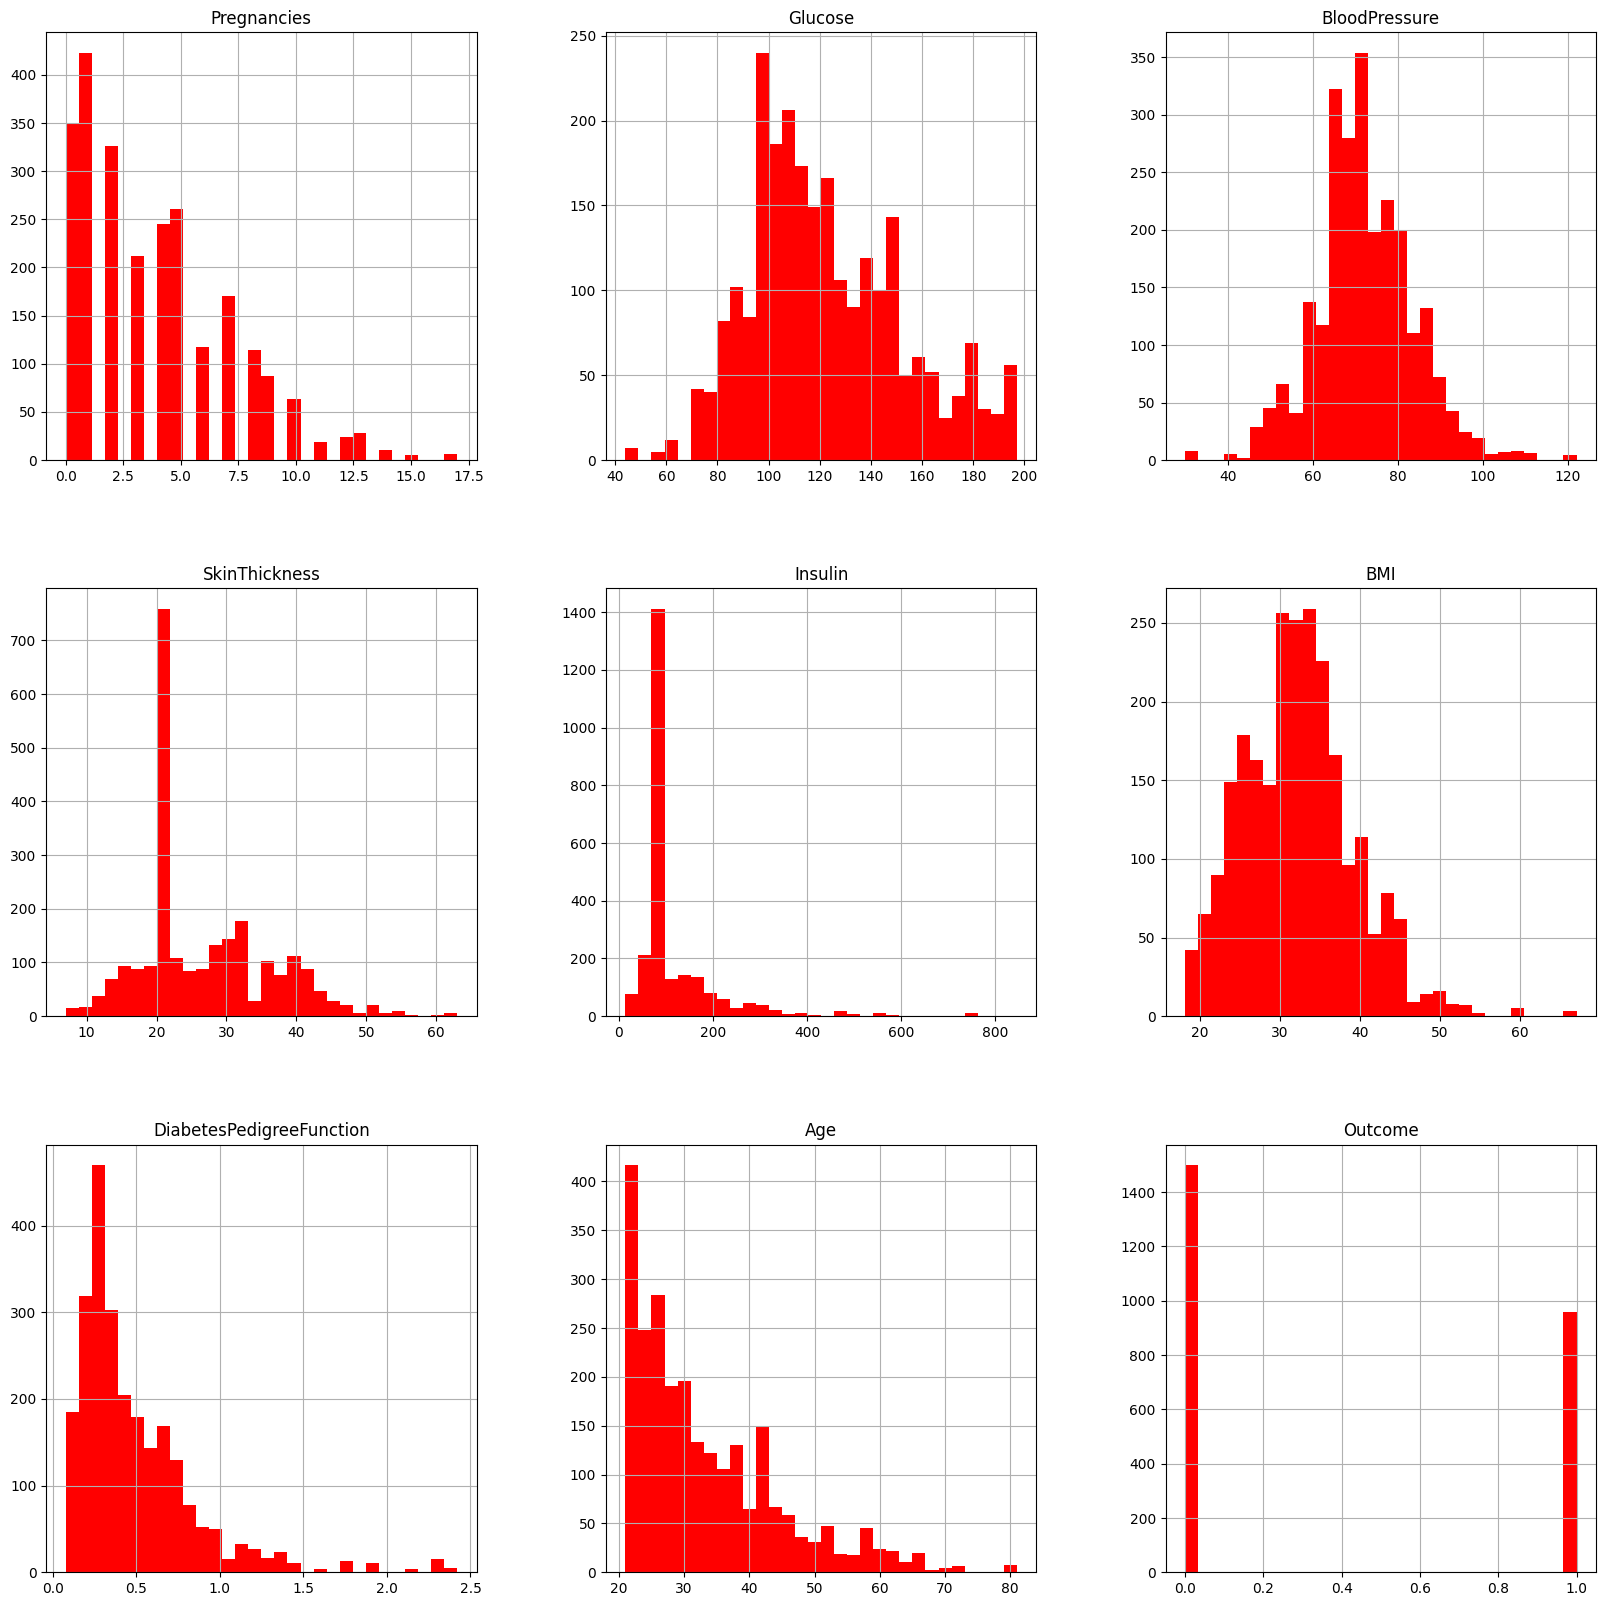

In [15]:
average_train_df.hist(bins=30, figsize=(20,20), color='r')

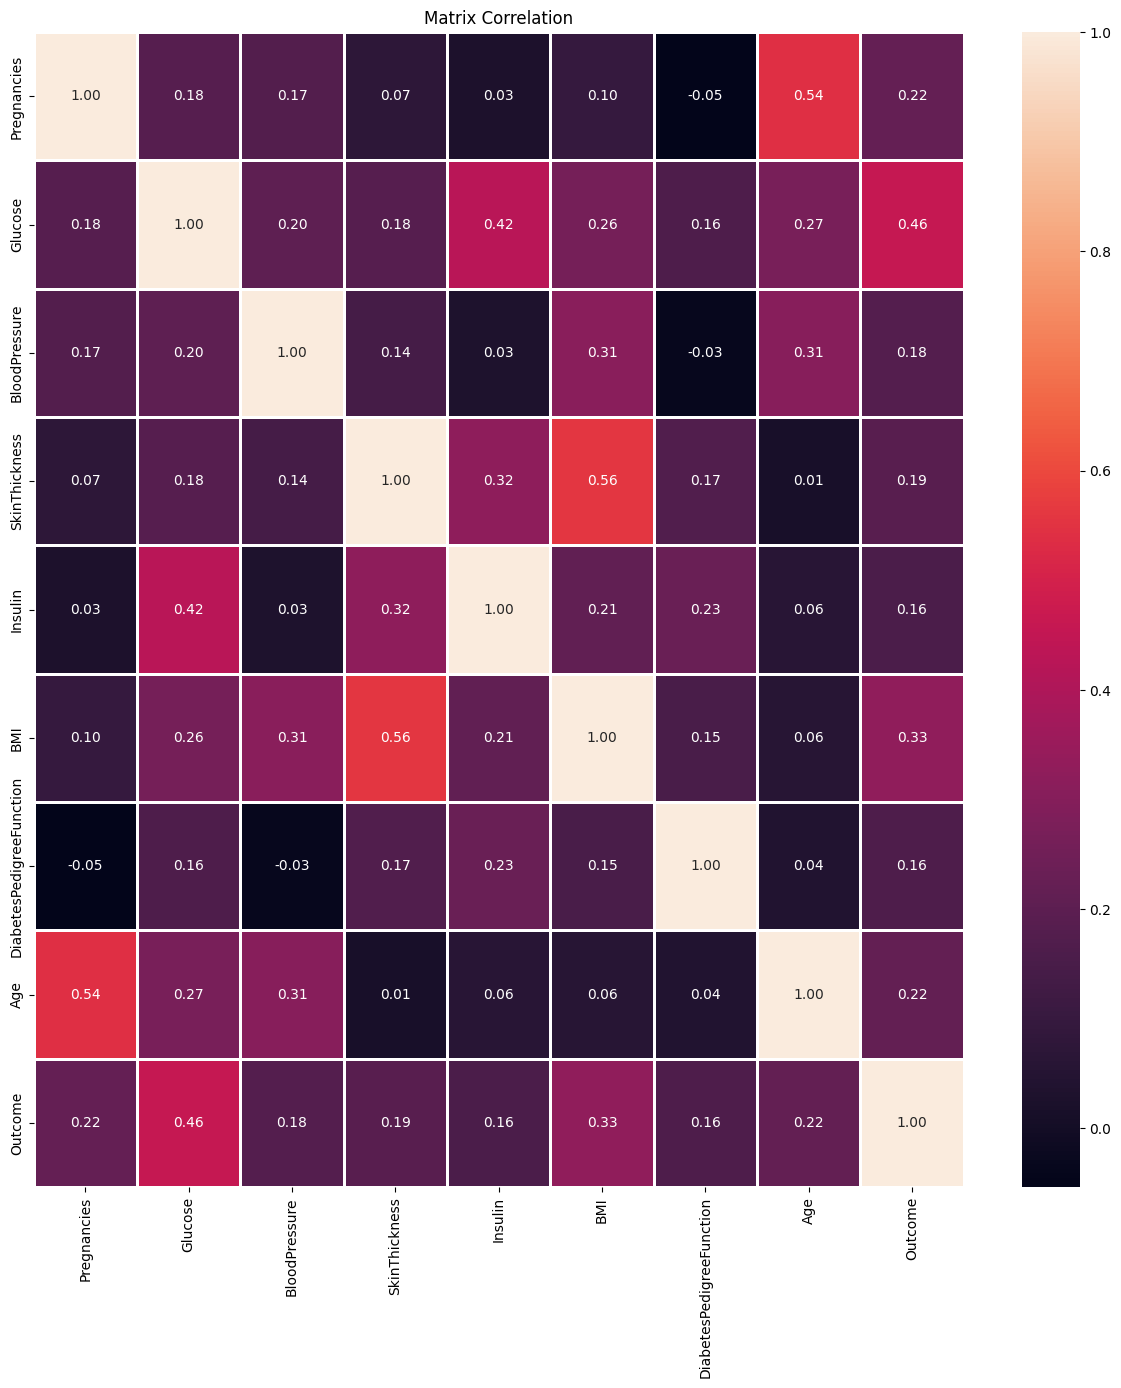

In [16]:
average_corr_matrix = average_train_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(average_corr_matrix, annot=True, linewidth=1, fmt='.2f')
plt.title("Matrix Correlation")
plt.show()

<Axes: >

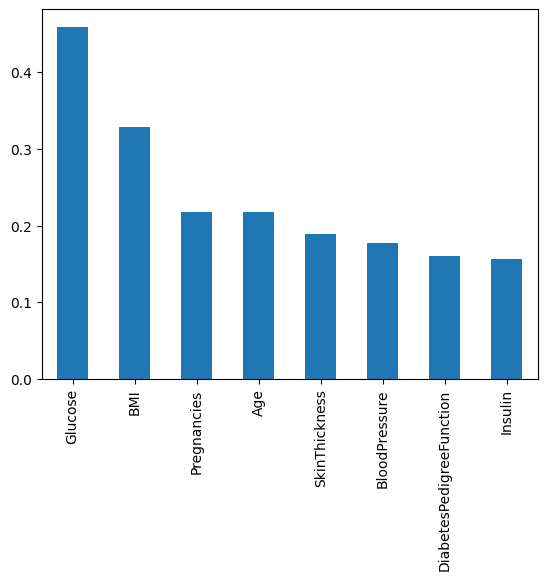

In [17]:
average_corr_matrix['Outcome'].drop('Outcome').sort_values(ascending = False).plot(kind = 'bar')

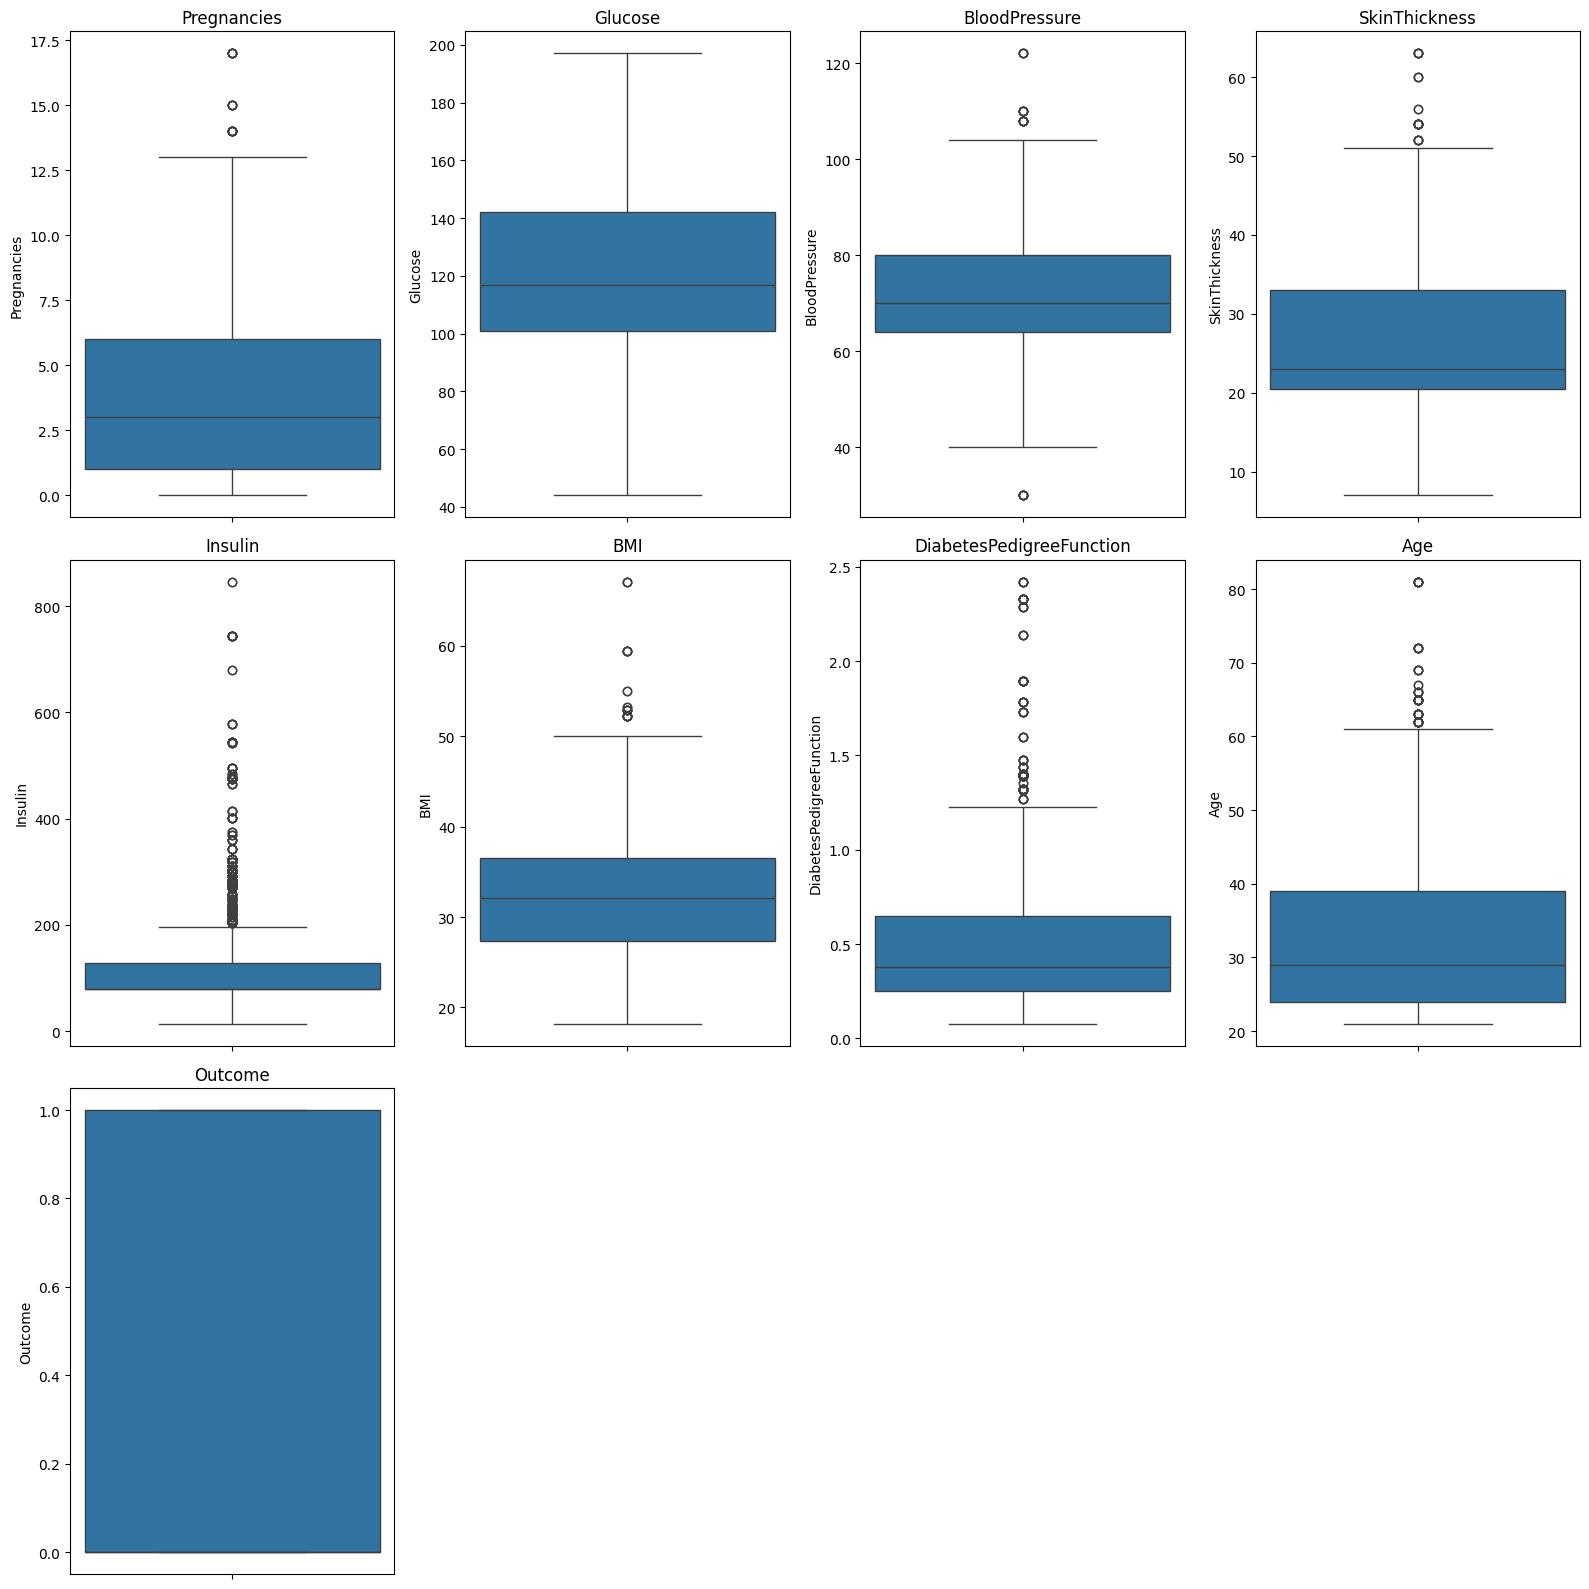

In [18]:
plt.figure(figsize=(16,16))
len_cols = len(average_train_df.columns)
rows = (len_cols +3)//4

for idx, col in enumerate(average_train_df.columns):
  plt.subplot(rows, 4, idx+1)
  plt.title(f"{col}")
  sns.boxplot(average_train_df[col])
  plt.tight_layout()
  plt.plot()

In [19]:
df_test = pd.read_csv('Training.csv')
df_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
2455,3,126,88,41,235,39.3,0.704,27,0
2456,4,123,62,0,0,32.0,0.226,35,1
2457,1,80,74,11,60,30.0,0.527,22,0
2458,1,96,64,27,87,33.2,0.289,21,0


In [20]:
X_train = average_train_df.drop('Outcome', axis=1)
y_train = average_train_df['Outcome']

X_test = df_test.drop('Outcome', axis=1)
y_test = df_test['Outcome']

In [21]:
print(X_train.shape)
print(X_test.shape)

(2460, 8)
(2460, 8)


In [22]:
average_Random_model = RandomForestClassifier()
average_Random_model.fit(X_train, y_train)

average_Random_model.score(X_test, y_test)

y_pred = average_Random_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")


Accuracy: 0.9341463414634147
Recall: 0.83125
Precision: 1.0
F1 Score: 0.9078498293515358
ROC AUC: 0.915625


In [23]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [24]:
new_data = pd.DataFrame({
    'Pregnancies': [9],
    'Glucose': [120],
    'BloodPressure': [72],
    'SkinThickness': [22],
    'Insulin': [56],
    'BMI': [20.8],
    'DiabetesPedigreeFunction': [0.733],
    'Age': [48]
})


Random_Forest_Prediction = average_Random_model.predict(new_data)

if Random_Forest_Prediction == 1:
    print("Diabetes")
else:
    print("No Diabetes")

No Diabetes


In [25]:
import math
math.sqrt(len(y_test))

49.59838707054898

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#make the column into scaled forms

In [27]:
test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train_scaled,y_train)
    
    train_scores.append(knn.score(X_train_scaled,y_train))
    test_scores.append(knn.score(X_test_scaled,y_test))

In [28]:
print(train_scores)

[1.0, 0.9995934959349594, 0.9991869918699187, 0.9959349593495935, 0.991869918699187, 0.9833333333333333, 0.9723577235772358, 0.9597560975609756, 0.9483739837398374, 0.9308943089430894, 0.9126016260162602, 0.884959349593496, 0.8804878048780488, 0.8735772357723577]


In [29]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [39]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 93.69918699186992 % and k = [1]


In [31]:
classifier_model = KNeighborsClassifier(n_neighbors=49, p=2, metric='euclidean')
classifier_model.fit(X_train_scaled, y_train)

KN_y_pred = classifier_model.predict(X_test_scaled)


print(f"Accuracy: {accuracy_score(y_test, KN_y_pred)}")
print(f"Recall: {recall_score(y_test, KN_y_pred)}")
print(f"Precision: {precision_score(y_test, KN_y_pred)}")
print(f"F1 Score: {f1_score(y_test, KN_y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, KN_y_pred)}")


Accuracy: 0.7686991869918699
Recall: 0.584375
Precision: 0.7674418604651163
F1 Score: 0.6635127143701951
ROC AUC: 0.7355208333333334


In [32]:
new_data = pd.DataFrame({
    'Pregnancies': [9],
    'Glucose': [120],
    'BloodPressure': [72],
    'SkinThickness': [22],
    'Insulin': [56],
    'BMI': [20.8],
    'DiabetesPedigreeFunction': [0.733],
    'Age': [48]
})


KN_Prediction = classifier_model.predict(new_data)

if KN_Prediction == 1:
    print("Diabetes")
else:
    print("No Diabetes")

Diabetes


In [33]:
param_grid = {
    'n_neighbors': range(1, 51),  # Test n_neighbors from 1 to 50
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_

In [34]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Best Cross-Validation Score: 0.9995934959349594


In [35]:
KN_y_pred = best_classifier.predict(X_test)


print(f"Accuracy: {accuracy_score(y_test, KN_y_pred)}")
print(f"Recall: {recall_score(y_test, KN_y_pred)}")
print(f"Precision: {precision_score(y_test, KN_y_pred)}")
print(f"F1 Score: {f1_score(y_test, KN_y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, KN_y_pred)}")

Accuracy: 0.8345528455284553
Recall: 0.653125
Precision: 0.8944365192582026
F1 Score: 0.7549668874172185
ROC AUC: 0.8018958333333334


In [36]:
new_data = pd.DataFrame({
    'Pregnancies': [9],
    'Glucose': [120],
    'BloodPressure': [72],
    'SkinThickness': [22],
    'Insulin': [56],
    'BMI': [20.8],
    'DiabetesPedigreeFunction': [0.733],
    'Age': [48]
})


KN_Prediction = best_classifier.predict(new_data)

if KN_Prediction == 1:
    print("Diabetes")
else:
    print("No Diabetes")

No Diabetes


In [37]:
print(f"KNeighbour Accuracy: {accuracy_score(y_test, KN_y_pred)}")
print(f"KNeighbour Recall: {recall_score(y_test, KN_y_pred)}")
print(f"KNeighbour Precision: {precision_score(y_test, KN_y_pred)}")
print(f"KNeighbour F1 Score: {f1_score(y_test, KN_y_pred)}")
print(f"KNeighbour ROC AUC: {roc_auc_score(y_test, KN_y_pred)}")


print(f"Decision Forest Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Decision ForestRecall: {recall_score(y_test, y_pred)}")
print(f"Decision ForestPrecision: {precision_score(y_test, y_pred)}")
print(f"Decision ForestF1 Score: {f1_score(y_test, y_pred)}")
print(f"Decision Forest ROC AUC: {roc_auc_score(y_test, y_pred)}")

KNeighbour Accuracy: 0.8345528455284553
KNeighbour Recall: 0.653125
KNeighbour Precision: 0.8944365192582026
KNeighbour F1 Score: 0.7549668874172185
KNeighbour ROC AUC: 0.8018958333333334
Decision Forest Accuracy: 0.9341463414634147
Decision ForestRecall: 0.83125
Decision ForestPrecision: 1.0
Decision ForestF1 Score: 0.9078498293515358
Decision Forest ROC AUC: 0.915625


Result Visualisation

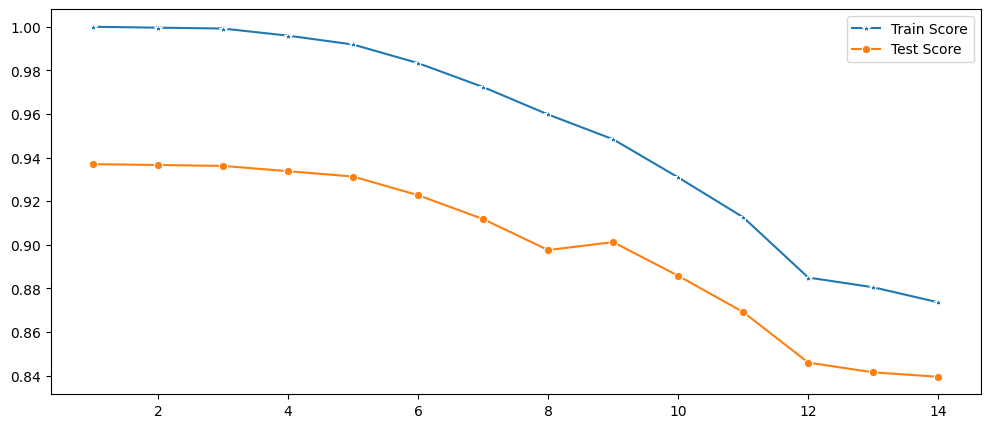

In [42]:
plt.figure(figsize=(12,5))

# Use x and y as keyword arguments for sns.lineplot
p = sns.lineplot(x=range(1, 15), y=train_scores, marker='*', label='Train Score')
p = sns.lineplot(x=range(1, 15), y=test_scores, marker='o', label='Test Score')


In [62]:
knn = KNeighborsClassifier(1)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.8345528455284553

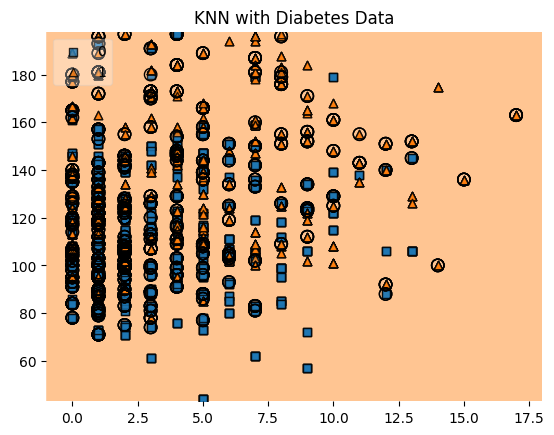

In [65]:
from mlxtend.plotting import plot_decision_regions

value = 20000
width = 20000
plot_decision_regions(X_train.values, y_train.values, clf=knn, legend=2, 
                      filler_feature_values={2: value, 3: value, 4: value, 5: value, 6: value, 7: value},
                      filler_feature_ranges={2: width, 3: width, 4: width, 5: width, 6: width, 7: width},
                      X_highlight=X_test.values)

# Adding axes annotations
#plt.xlabel('sepal length [cm]')
#plt.ylabel('petal length [cm]')
plt.title('KNN with Diabetes Data')
plt.show()

In [59]:
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1426,74,1500
1,333,627,960
All,1759,701,2460


Text(0.5, 23.52222222222222, 'Predicted label')

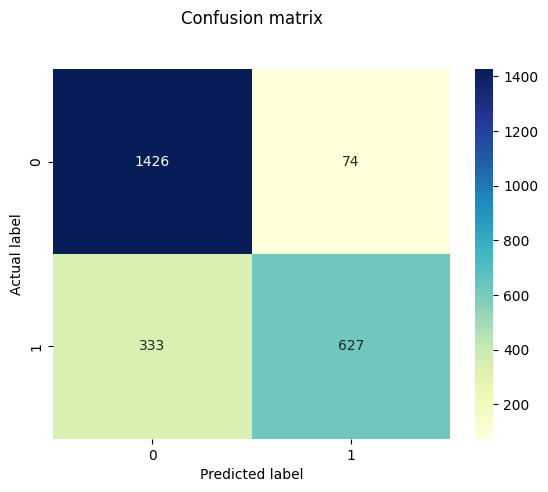

In [61]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Cases in which the doctor predicted YES (they have the disease), and they do have the disease will be termed as TRUE POSITIVES (TP). The doctor has correctly predicted that the patient has the disease.¶

Cases in which the doctor predicted NO (they do not have the disease), and they don’t have the disease will be termed as TRUE NEGATIVES (TN). The doctor has correctly predicted that the patient does not have the disease.

Cases in which the doctor predicted YES, and they do not have the disease will be termed as FALSE POSITIVES (FP). Also known as “Type I error”.

Cases in which the doctor predicted NO, and they have the disease will be termed as FALSE NEGATIVES (FN). Also known as “Type II error”.